In [1]:
# Data Array Imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Math
import math

# Plot imports
%matplotlib inline
import matplotlib.pyplot as plt
from ggplot import *
#import seaborn as sns
#sns.set_style('whitegrid')

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

# For evaluating our ML results
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve

# season DataFrame is simply the regular/real seaon connected to the post/play off data
real_season = pd.read_csv('passes.csv')
season = pd.read_csv('combined.csv')
post_season = pd.read_csv('passes_post.csv')


# The average is found to convert from integer to decimals since logistic regression requires continuity.
def find_avg(x):
    return x/16.0

In [2]:
# Dummy variables to remove collinearity, e.g. If a variable can be one of 3 (WR, RB, TE), if it is neither RB or TE, 
# it can only be WR so we can aurgue they are correlated
receiver_pos_dummies = pd.get_dummies(season['Receiver Pos'])
down_dummies = pd.get_dummies(season['Down'])
down_dummies.columns = ['Down 1', 'Down 2', 'Down 3', 'Down 4']
team_dummies = pd.get_dummies(season['Team'])
receiver_id_dummies = pd.get_dummies(season['Receiver ID'])
qb_dummies = pd.get_dummies(season['QB'])

In [3]:
# Prepare the dataframe
training_data = season.drop(['Receiver Pos', 'Down', 'Team', 'Intercepted', 'Success','Receiver ID', 'QB'], axis=1)
dummies = pd.concat([qb_dummies, receiver_pos_dummies, receiver_id_dummies, down_dummies, team_dummies], axis=1)
training_data = pd.concat([training_data, dummies], axis=1)

# Apply avg and drop columns
training_data['QB Sacks'] = training_data['QB Sacks'].apply(find_avg)
training_data['QB Fumbles'] = training_data['QB Fumbles'].apply(find_avg)
training_data['QB Rush Att'] = training_data['QB Rush Att'].apply(find_avg)

# Remove columns to get rid of collinearity
training_data = training_data.drop(['B.Roethlisberger','RB', 1, 'Down 4', 'PIT'], axis=1)

# Season succesful passes
Y_season = season['Success']

'''Reg season length 0 - 17821'''

Y = np.ravel(Y_season)

In [4]:
#Logtistic Model

log_model = LogisticRegression()
log_model.fit(training_data, Y)

# Model accuracy based on all of the data
print 'Model Logistic'
print log_model.score(training_data, Y)

#Null Error Rate
print 1 - Y.mean()
print '\n'

coeff_df = DataFrame(zip(training_data.columns, np.transpose(log_model.coef_)))
coeff_df.to_csv('result1.csv')

Model Logistic
0.6362631288
0.380873410724




In [5]:
'''Model Naive Bayes'''
gnb = GaussianNB()
gnb.fit(training_data, Y)

# Model accuracy based on all of the data
print 'Model Naive Bayes'
print gnb.score(training_data, Y)

#Null Error Rate
print 1 - Y.mean()
print '\n'

Model Naive Bayes
0.478330569375
0.380873410724




In [6]:
'''Model Decision Tree'''
clf = tree.DecisionTreeClassifier()
clf.fit(training_data, Y)

# Model accuracy based on all of the data
print 'Model Decision Tree'
print clf.score(training_data, Y)

#Null Error Rate
print 1 - Y.mean()
print '\n'

Model Decision Tree
0.785572139303
0.380873410724




In [7]:
#Split the dataset into regular and post season data
X_train = training_data[:17822]
X_test = training_data[17822:]

y_train = np.ravel(Y_season[:17822])
y_test = np.ravel(Y_season[17822:])

In [8]:
log_model2 = LogisticRegression()
log_model2.fit(X_train, y_train)
class_predict = log_model2.predict(X_test)

preds = log_model2.predict_proba(X_test)[:,1]

df_confusion = pd.crosstab(y_test, class_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

# Accuracy and null error rate
print 'Logistic Model - with split'
print metrics.accuracy_score(y_test, class_predict)
print 1 - y_test.mean()
print '\n'

# Coeff and the impactfulness on the model
coeff_df = DataFrame(zip(X_train.columns, np.transpose(log_model2.coef_)))
coeff_df.to_csv('result2.csv')

# Compute confusion matrix
#cm1 = confusion_matrix(y_test, class_predict)
print('Confusion matrix, without normalization')
print(df_confusion)
print '\n'

#cm2 = cm1 / cm1.astype(np.float).sum(axis=1)
np.set_printoptions(precision=2)
print('Confusion matrix, with normalization')
print(df_conf_norm)

Logistic Model - with split
0.55223880597
0.429104477612


Confusion matrix, without normalization
Predicted   0    1  All
Actual                 
0           6  109  115
1          11  142  153
All        17  251  268


Confusion matrix, with normalization
Predicted         0         1       All
Actual                                 
0          0.026087  0.356209  0.214552
1          0.047826  0.464052  0.285448
All        0.073913  0.820261  0.500000


In [9]:
fpr, tpr, thresholds = roc_curve(y_test, preds)#, pos_label=2)

C:\Users\Oliver\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


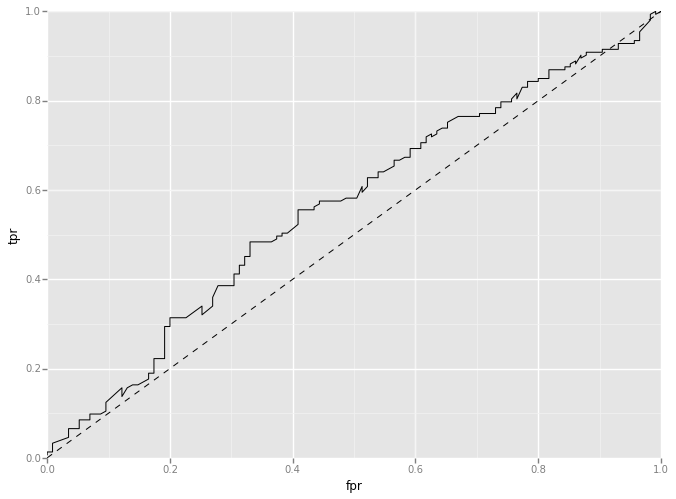

<ggplot: (34780985)>

In [10]:
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

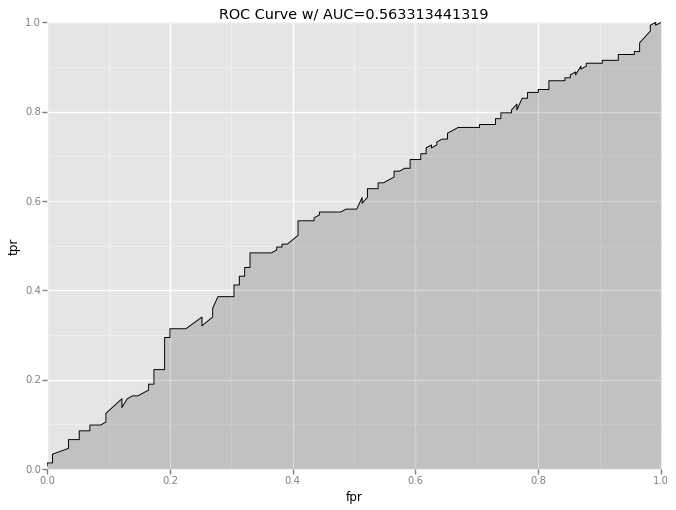

<ggplot: (45264844)>

In [11]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) + geom_area(alpha=0.2) + geom_line(aes(y='tpr')) + ggtitle("ROC Curve w/ AUC=%s" % str(auc))

In [12]:
log_model3 = LogisticRegression(penalty='l1')
log_model3.fit(X_train, y_train)
class_predict = log_model3.predict(X_test)

preds = log_model3.predict_proba(X_test)[:,1]

df_confusion = pd.crosstab(y_test, class_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

# Accuracy and null error rate
print 'Logistic Model - with split and l1 penalty'
print metrics.accuracy_score(y_test, class_predict)
print 1 - y_test.mean()
print '\n'

# Coeff and the impactfulness on the model
coeff_df = DataFrame(zip(X_train.columns, np.transpose(log_model3.coef_)))
coeff_df.to_csv('result3.csv')

# Compute confusion matrix
cm1 = confusion_matrix(y_test, class_predict)
print('Confusion matrix, without normalization')
print(df_confusion)
print '\n'

cm2 = cm1 / cm1.astype(np.float).sum(axis=1)
np.set_printoptions(precision=2)
print('Confusion matrix, with normalization')
print(df_conf_norm)

Logistic Model - with split and l1 penalty
0.548507462687
0.429104477612


Confusion matrix, without normalization
Predicted   0    1  All
Actual                 
0           4  111  115
1          10  143  153
All        14  254  268


Confusion matrix, with normalization
Predicted         0         1       All
Actual                                 
0          0.017391  0.362745  0.214552
1          0.043478  0.467320  0.285448
All        0.060870  0.830065  0.500000


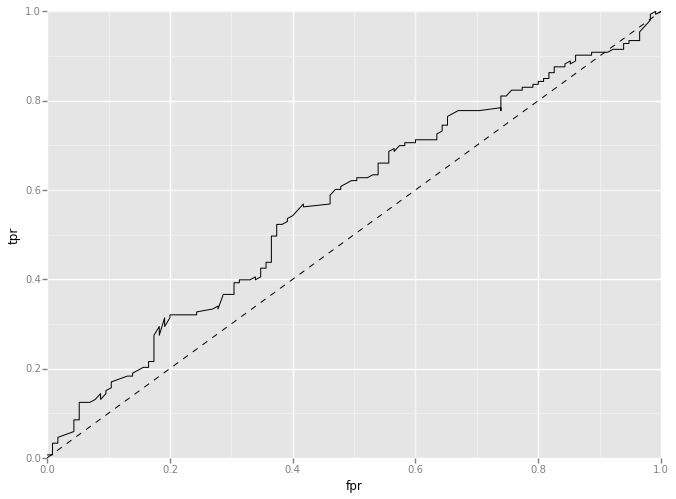

<ggplot: (34652662)>

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, preds)#, pos_label=2)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

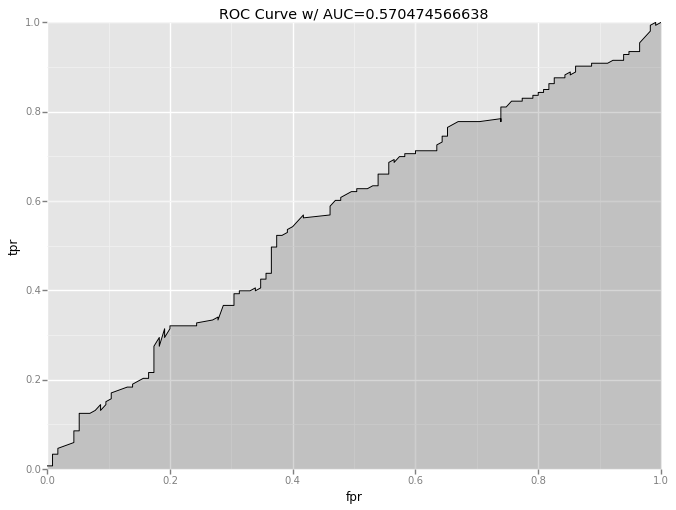

<ggplot: (34627546)>

In [14]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) + geom_area(alpha=0.2) + geom_line(aes(y='tpr')) + ggtitle("ROC Curve w/ AUC=%s" % str(auc))

In [15]:
'''Decision Tree'''

model4 = tree.DecisionTreeClassifier()
model4.fit(X_train, y_train)
class_predict = model4.predict(X_test)
preds = model4.predict_proba(X_test)[:,1]

df_confusion = pd.crosstab(y_test, class_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

# Accuracy and null error rate
print 'Decision Tree Model - with split'
print metrics.accuracy_score(y_test, class_predict)
print 1 - y_test.mean()
print '\n'

# Compute confusion matrix
#cm1 = confusion_matrix(y_test, class_predict)
print('Confusion matrix, without normalization')
print(df_confusion)
print '\n'

#cm2 = cm1 / cm1.astype(np.float).sum(axis=1)
np.set_printoptions(precision=2)
print('Confusion matrix, with normalization')
print(df_conf_norm)

Decision Tree Model - with split
0.578358208955
0.429104477612


Confusion matrix, without normalization
Predicted   0    1  All
Actual                 
0          40   75  115
1          38  115  153
All        78  190  268


Confusion matrix, with normalization
Predicted         0         1       All
Actual                                 
0          0.173913  0.245098  0.214552
1          0.165217  0.375817  0.285448
All        0.339130  0.620915  0.500000


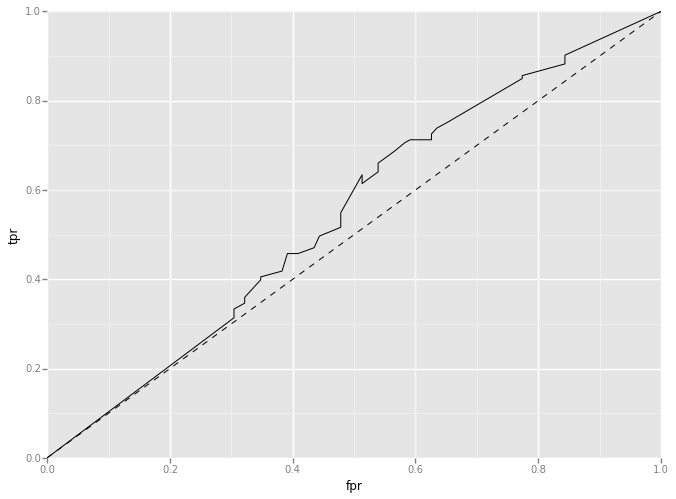

<ggplot: (45709046)>

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, preds)#, pos_label=2)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

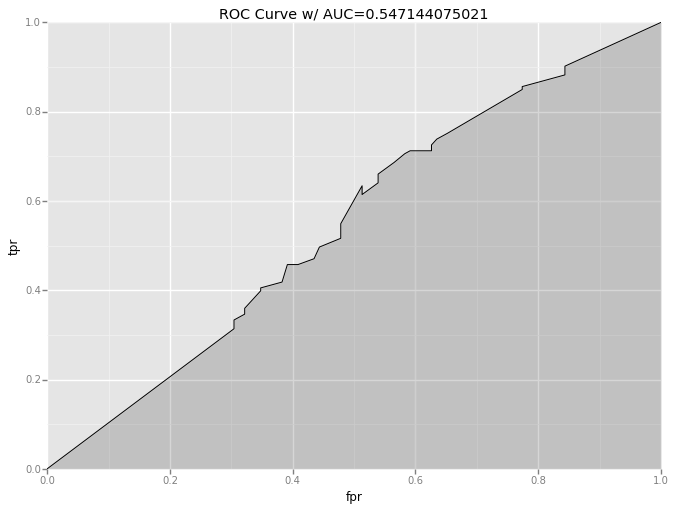

<ggplot: (45364554)>

In [17]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) + geom_area(alpha=0.2) + geom_line(aes(y='tpr')) + ggtitle("ROC Curve w/ AUC=%s" % str(auc))

In [18]:
'''Naive Bayes'''

model5 = GaussianNB()
model5.fit(X_train, y_train)
class_predict = model5.predict(X_test)
preds = model5.predict_proba(X_test)[:,1]

df_confusion = pd.crosstab(y_test, class_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

# Accuracy and null error rate
print 'Naive Bayes Model - with split'
print metrics.accuracy_score(y_test, class_predict)
print 1 - y_test.mean()
print '\n'

# Compute confusion matrix
#cm1 = confusion_matrix(y_test, class_predict)
print('Confusion matrix, without normalization')
print(df_confusion)
print '\n'

#cm2 = cm1 / cm1.astype(np.float).sum(axis=1)
np.set_printoptions(precision=2)
print('Confusion matrix, with normalization')
print(df_conf_norm)

Naive Bayes Model - with split
0.485074626866
0.429104477612


Confusion matrix, without normalization
Predicted    0   1  All
Actual                 
0           98  17  115
1          121  32  153
All        219  49  268


Confusion matrix, with normalization
Predicted         0         1       All
Actual                                 
0          0.426087  0.055556  0.214552
1          0.526087  0.104575  0.285448
All        0.952174  0.160131  0.500000


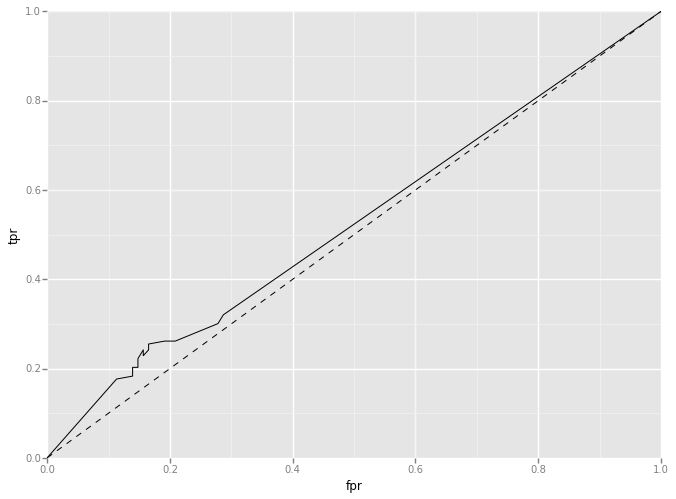

<ggplot: (45364558)>

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, preds)#, pos_label=2)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

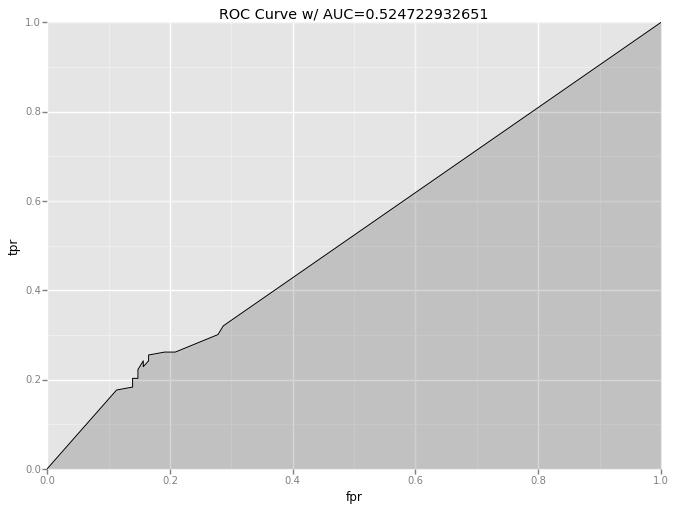

<ggplot: (34722974)>

In [20]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) + geom_area(alpha=0.2) + geom_line(aes(y='tpr')) + ggtitle("ROC Curve w/ AUC=%s" % str(auc))